In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,0.0,0.0,NaN,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,0.0,0.0,0.0,...,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
37625,NaN,NaN,International,2020-03-08,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37626,NaN,NaN,International,2020-03-09,NaN,NaN,0.000,NaN,NaN,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37627,NaN,NaN,International,2020-03-10,696.0,-9.0,-1.286,7.0,1.0,0.143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Bonaire Sint Eustatius and Saba',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Democratic Republic of Congo', 'Congo', 'Colombia', 'Comoros',
       'Cape Verde', 'Costa Rica', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica',
       'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt',
       'Eritrea', 'Western Sahara', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'Fiji', 'Falkland Islands', 'France',

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


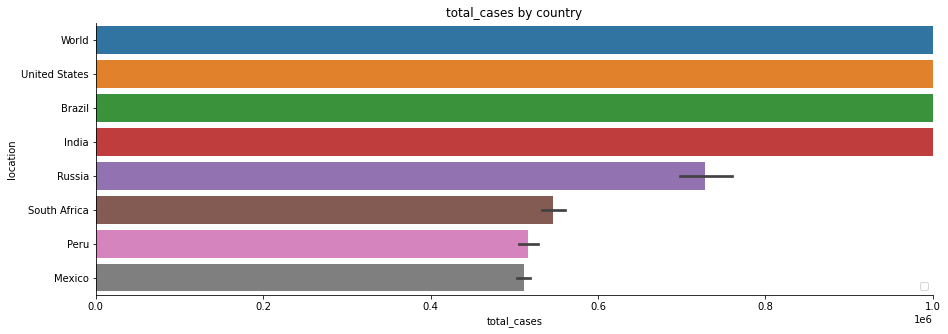

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


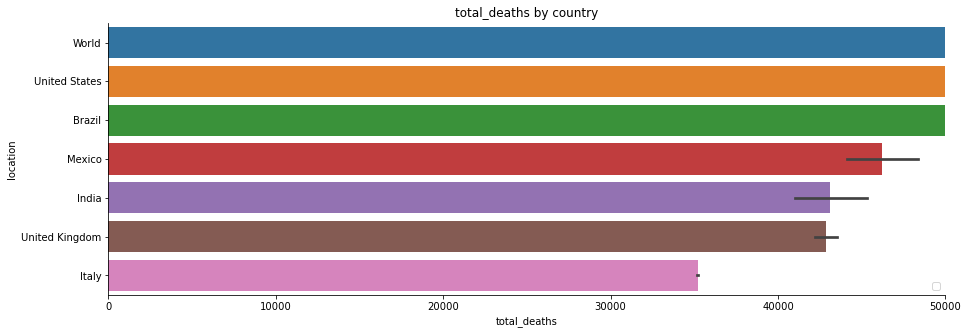

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


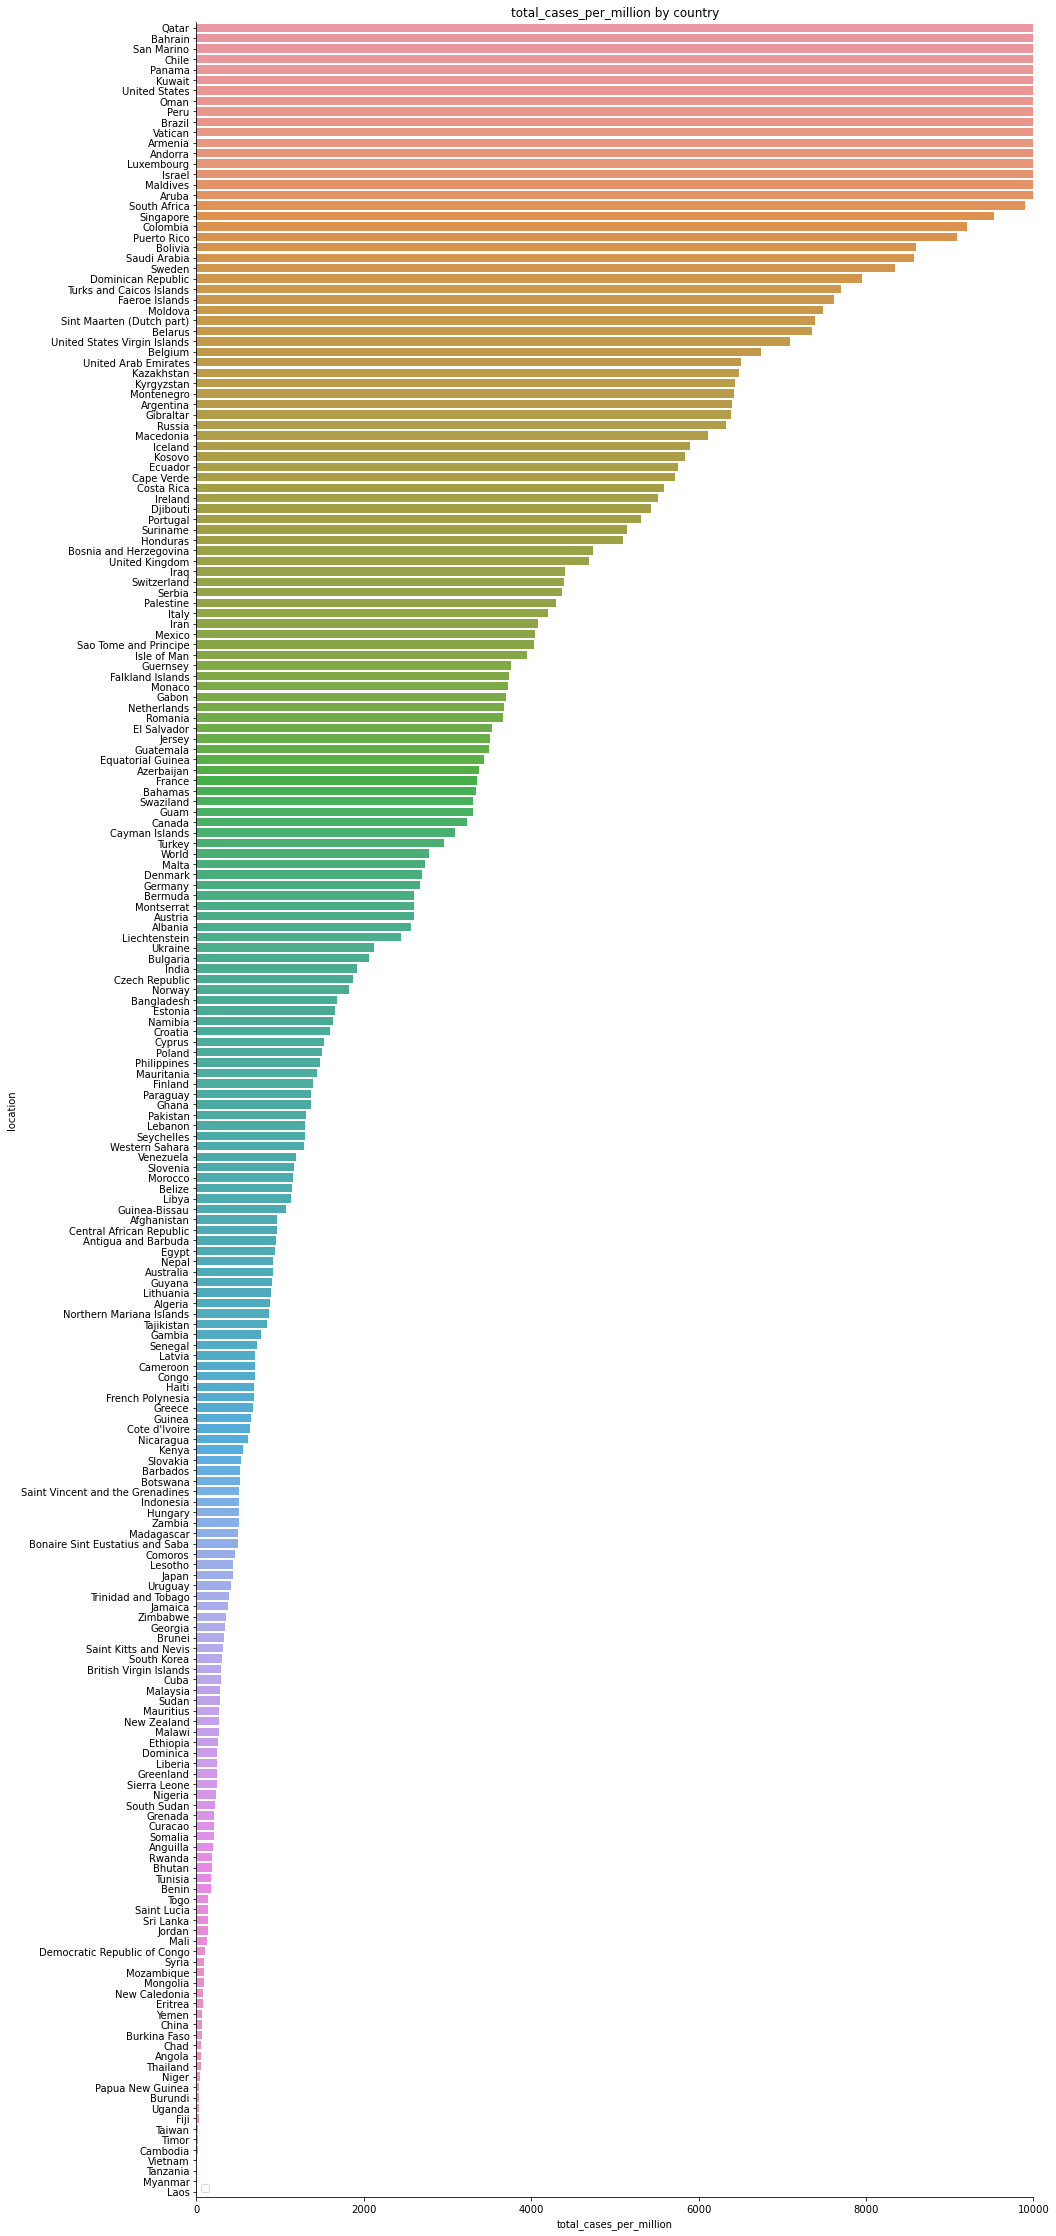

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


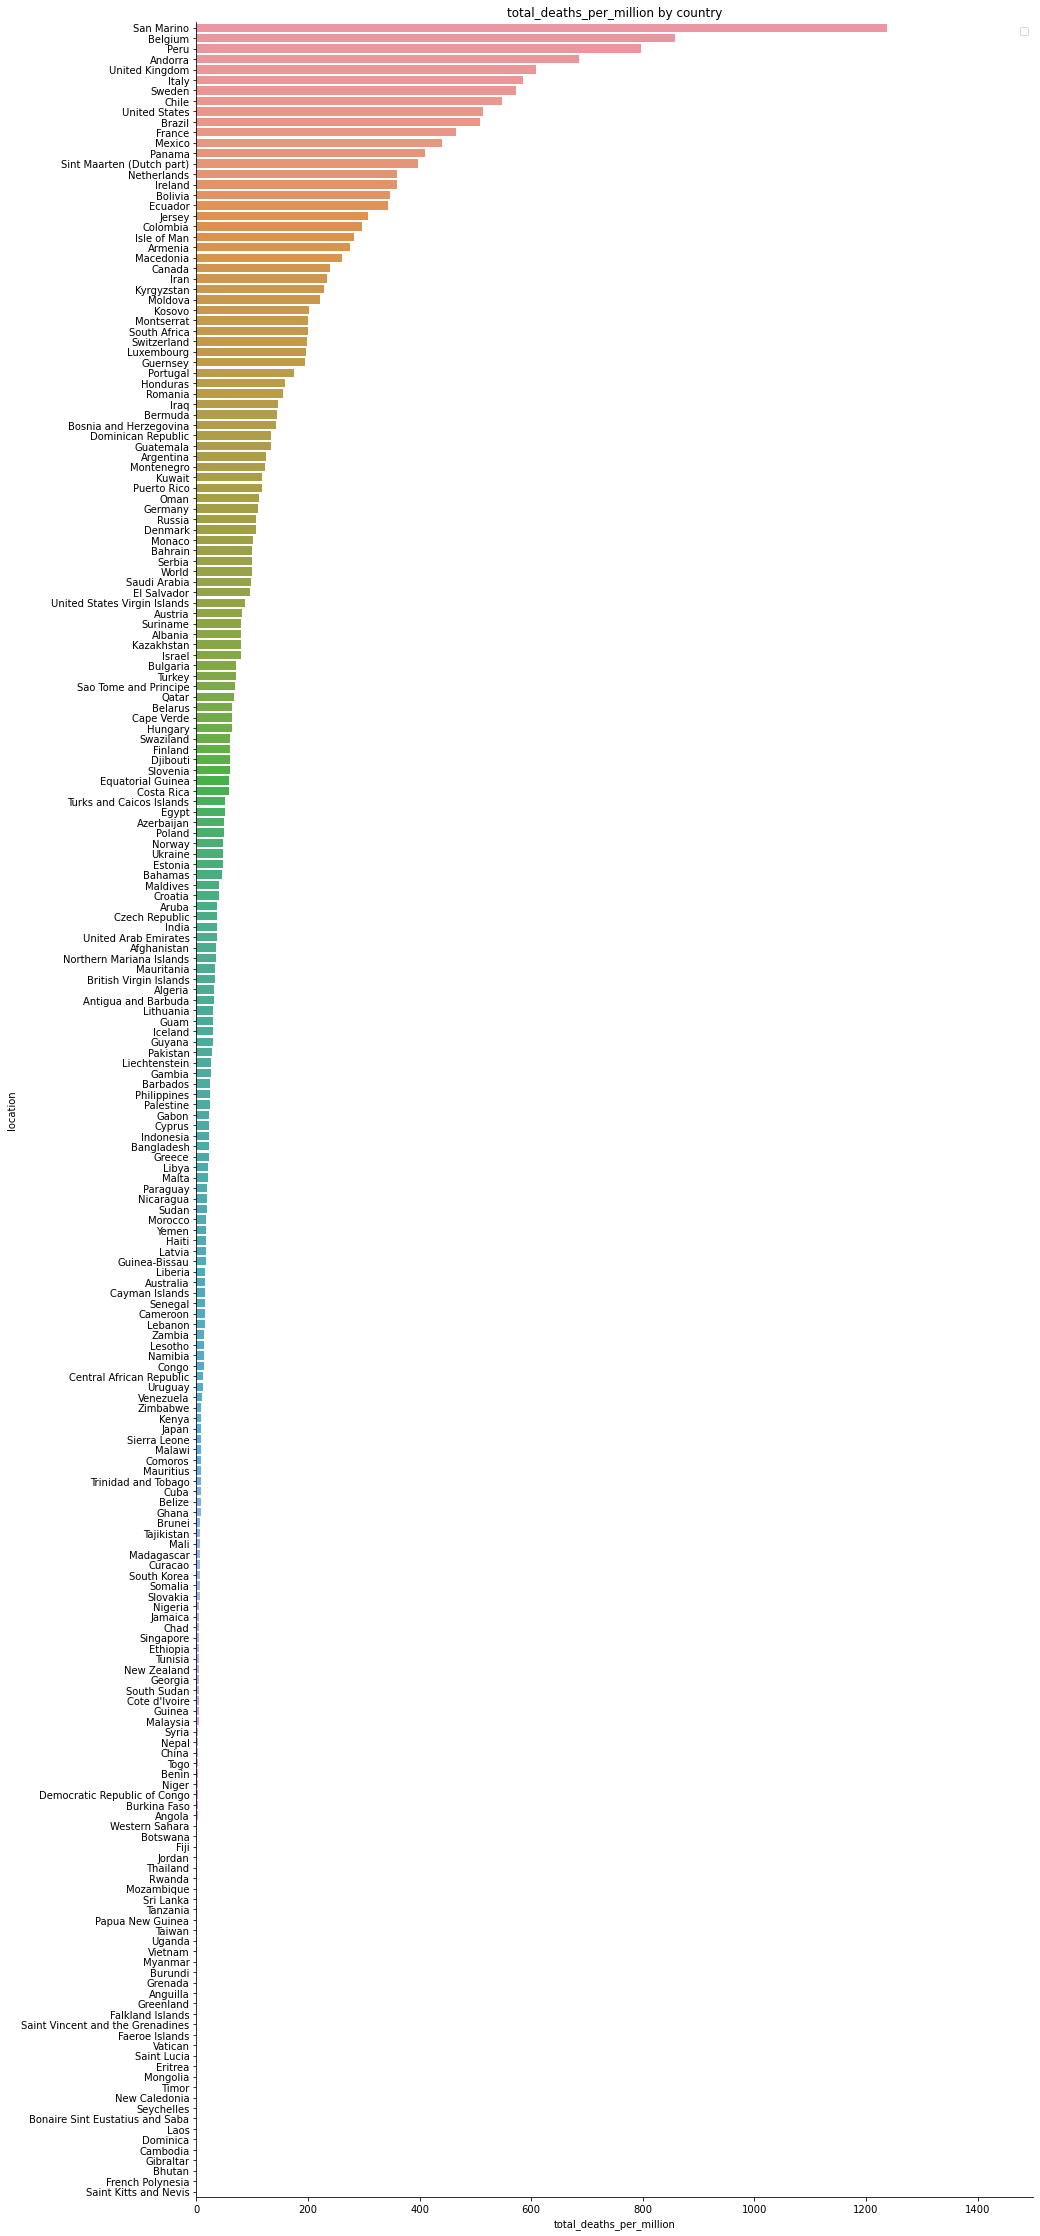

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

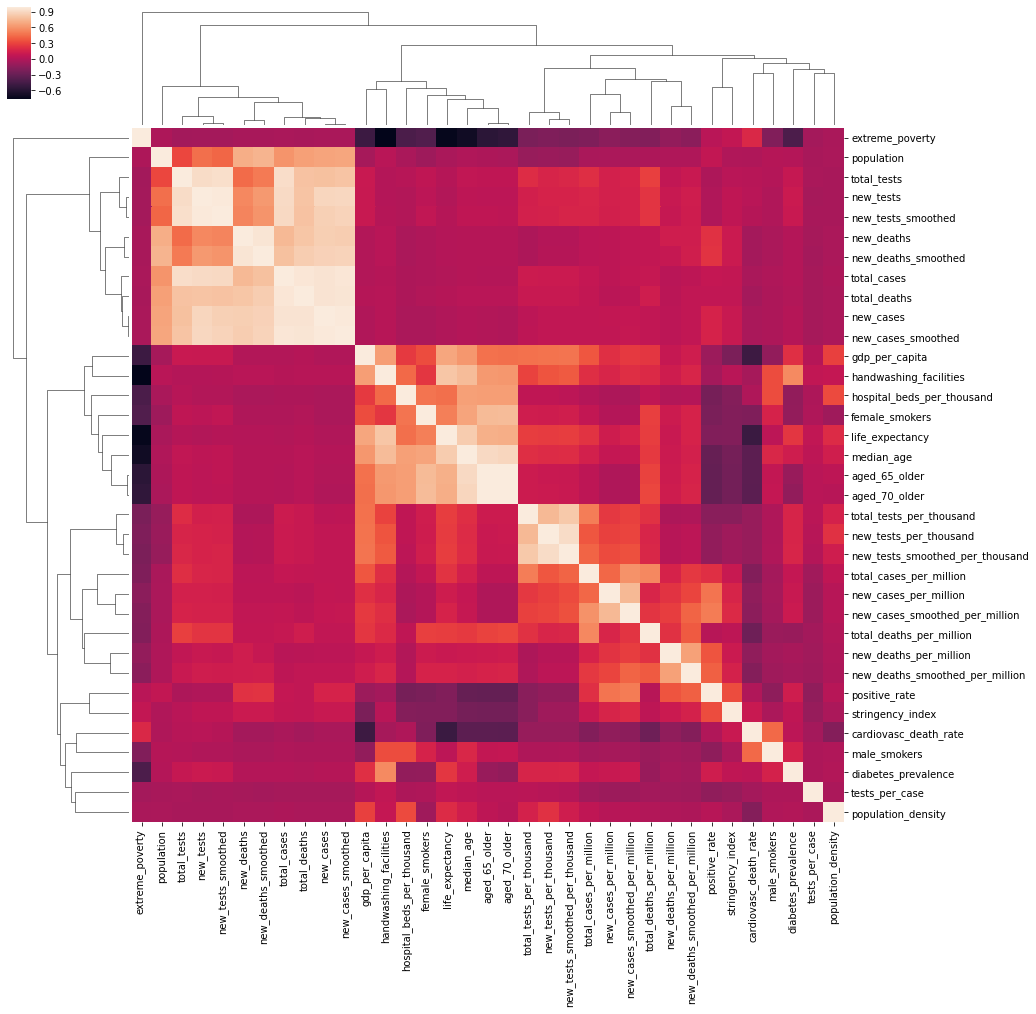

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996162121509146 (+/- 0.00021562355417053104)
Coef :  [1.04299423e+00 7.88551456e-05 8.44896239e-05]
3 Last_days :  [[21214898 21474101 21689832]]
Today :  21689832
Prediction + :  506400
Tomorow :  22196232
                                     
--------- Total Death -----------------
                                     
R^2: 0.9995882709948188 (+/- 2.4853237090373922e-05)
Coef :  [-0.09025187  0.53260013  0.56734817]
3 Last_days :  [[760434 766087 770273]]
Today :  770273
Prediction + :  8274
Tomorow :  778547
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9885305686861067 (+/- 0.007281717851642361)
Coef :  [-0.67641742  0.7370692   0.94022035]
3 Last_days :  [[212211 215521 218536]]
Today :  218536
Prediction + :  2552
Tomorow :  221088
                                     
--------- Total Death -----------------
                                     
R^2: 0.4279395088406049 (+/- 0.7925993538969293)
Coef :  [-0.75566687  0.7883404   0.96644963]
3 Last_days :  [[30406 30409 30410]]
Today :  30410
Prediction + :  26
Tomorow :  30436
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7742338332801975 (+/- 0.16049477090210354)
Coef :  [-0.32135761 -0.0257497   1.34138184]
3 Last_days :  [[89214 89279 89375]]
Today :  89375
Prediction + :  70
Tomorow :  89445
                                     
--------- Total Death -----------------
                                     
R^2: -1525.1269098854418 (+/- 2157.958631165952)
Coef :  [-0.07655187  0.01241316  1.05619739]
3 Last_days :  [[4701 4703 4703]]
Today :  4703
Prediction + :  7
Tomorow :  4710
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6250575468416875 (+/- 0.5287998746084489)
Coef :  [-0.83784918  0.90518518  0.93187458]
3 Last_days :  [[252809 253438 253915]]
Today :  253915
Prediction + :  662
Tomorow :  254577
                                     
--------- Total Death -----------------
                                     
R^2: 0.957688992302244 (+/- 0.03726436565311822)
Coef :  [-0.83603012  0.90420668  0.93107247]
3 Last_days :  [[35234 35392 35396]]
Today :  35396
Prediction + :  156
Tomorow :  35552
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7811626028302227 (+/- 0.2994876641228387)
Coef :  [-0.72141424  0.75542059  0.96602968]
3 Last_days :  [[342813 342813 342813]]
Today :  342813
Prediction + :  479
Tomorow :  343292
                                     
--------- Total Death -----------------
                                     
R^2: 0.23095403446927357 (+/- 0.9032985498207471)
Coef :  [-0.7169183   0.60716235  1.10875371]
3 Last_days :  [[28617 28617 28617]]
Today :  28617
Prediction + :  8
Tomorow :  28625
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.995550928116372 (+/- 0.0059161143386686045)
Coef :  [0.10480397 0.45225656 0.46346609]
3 Last_days :  [[5313080 5361165 5403269]]
Today :  5403269
Prediction + :  93134
Tomorow :  5496403
                                     
--------- Total Death -----------------
                                     
R^2: 0.4977538812439208 (+/- 0.708494104786795)
Coef :  [-0.63756062  0.77249567  0.86719861]
3 Last_days :  [[168446 169481 170052]]
Today :  170052
Prediction + :  1190
Tomorow :  171242
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.998934271087538 (+/- 0.0001448988543274482)
Coef :  [-0.78265886  0.87751192  0.90524685]
3 Last_days :  [[316367 317444 318484]]
Today :  318484
Prediction + :  1204
Tomorow :  319688
                                     
--------- Total Death -----------------
                                     
R^2: 0.33633421017051907 (+/- 0.6727478877349402)
Coef :  [-0.45320129  0.31820883  1.13422099]
3 Last_days :  [[41357 41361 41366]]
Today :  41366
Prediction + :  61
Tomorow :  41427
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.992000845682108 (+/- 0.009349744495945432)
Coef :  [-0.81456238  0.86705378  0.94699892]
3 Last_days :  [[222828 223453 224014]]
Today :  224014
Prediction + :  658
Tomorow :  224672
                                     
--------- Total Death -----------------
                                     
R^2: 0.45922148483453346 (+/- 0.7523005482883688)
Coef :  [-0.79777234  0.84270418  0.95447818]
3 Last_days :  [[9231 9231 9232]]
Today :  9232
Prediction + :  7
Tomorow :  9239
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.36685545173043815 (+/- 0.8948967960419139)
Coef :  [0.16212933 0.42589035 0.42503528]
3 Last_days :  [[338825 341070 343203]]
Today :  343203
Prediction + :  4033
Tomorow :  347236
                                     
--------- Total Death -----------------
                                     
R^2: 0.9058333106770663 (+/- 0.13284283311837847)
Coef :  [-0.05035664  0.53559675  0.52884772]
3 Last_days :  [[19331 19492 19639]]
Today :  19639
Prediction + :  252
Tomorow :  19891
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9984646542036822 (+/- 0.0019101403015466206)
Coef :  [-0.76166596  0.85939417  0.89944891]
3 Last_days :  [[246861 248117 249309]]
Today :  249309
Prediction + :  1102
Tomorow :  250411
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993796892010671 (+/- 0.000543714466584063)
Coef :  [-0.82453621  0.9012802   0.92026715]
3 Last_days :  [[5934 5955 5974]]
Today :  5974
Prediction + :  19
Tomorow :  5993
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4740406408545292 (+/- 0.7410287200145175)
Coef :  [-0.15135638  0.47590797  0.69496525]
3 Last_days :  [[3275520 3317096 3340197]]
Today :  3340197
Prediction + :  68793
Tomorow :  3408990
                                     
--------- Total Death -----------------
                                     
R^2: 0.5144817943579107 (+/- 0.6817006299942587)
Coef :  [-0.20640063  0.55146918  0.66810284]
3 Last_days :  [[106523 107232 107852]]
Today :  107852
Prediction + :  1556
Tomorow :  109408
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(21689832, 770273, 22196232, 778547),
 (218536, 30410, 221088, 30436),
 (253915, 35396, 254577, 35552),
 (342813, 28617, 343292, 28625),
 (5403269, 170052, 5496403, 171242),
 (89375, 4703, 89445, 4710),
 (318484, 41366, 319688, 41427),
 (224014, 9232, 224672, 9239),
 (343203, 19639, 347236, 19891),
 (249309, 5974, 250411, 5993),
 (3340197, 107852, 3408990, 109408)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-17,France,221088.0,0.0,30436.0,0.0,0.0,0.0
0,2020-08-17,China,89445.0,0.0,4710.0,0.0,0.0,0.0
0,2020-08-17,Italy,254577.0,0.0,35552.0,0.0,0.0,0.0
0,2020-08-17,Spain,343292.0,0.0,28625.0,0.0,0.0,0.0
0,2020-08-17,United States,5496403.0,0.0,171242.0,0.0,0.0,0.0
0,2020-08-17,World,22196232.0,0.0,778547.0,0.0,0.0,0.0
0,2020-08-17,United Kingdom,319688.0,0.0,41427.0,0.0,0.0,0.0
0,2020-08-17,Germany,224672.0,0.0,9239.0,0.0,0.0,0.0
0,2020-08-17,Iran,347236.0,0.0,19891.0,0.0,0.0,0.0
0,2020-08-17,Turkey,250411.0,0.0,5993.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")